In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, func

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
inspector = inspect(engine)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the date and precipitation scores
results=session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date).all()

results


[(0.0, '2016-08-23'),
 (0.15, '2016-08-23'),
 (0.05, '2016-08-23'),
 (None, '2016-08-23'),
 (0.02, '2016-08-23'),
 (1.79, '2016-08-23'),
 (0.7, '2016-08-23'),
 (0.08, '2016-08-24'),
 (2.15, '2016-08-24'),
 (2.28, '2016-08-24'),
 (None, '2016-08-24'),
 (1.22, '2016-08-24'),
 (2.15, '2016-08-24'),
 (1.45, '2016-08-24'),
 (0.08, '2016-08-25'),
 (0.08, '2016-08-25'),
 (0.0, '2016-08-25'),
 (0.0, '2016-08-25'),
 (0.21, '2016-08-25'),
 (0.06, '2016-08-25'),
 (0.11, '2016-08-25'),
 (0.0, '2016-08-26'),
 (0.03, '2016-08-26'),
 (0.02, '2016-08-26'),
 (0.04, '2016-08-26'),
 (0.0, '2016-08-26'),
 (0.01, '2016-08-26'),
 (0.0, '2016-08-27'),
 (0.18, '2016-08-27'),
 (0.02, '2016-08-27'),
 (0.0, '2016-08-27'),
 (0.12, '2016-08-27'),
 (None, '2016-08-27'),
 (0.01, '2016-08-28'),
 (0.14, '2016-08-28'),
 (0.14, '2016-08-28'),
 (0.14, '2016-08-28'),
 (0.6, '2016-08-28'),
 (2.07, '2016-08-28'),
 (0.0, '2016-08-29'),
 (0.17, '2016-08-29'),
 (0.04, '2016-08-29'),
 (None, '2016-08-29'),
 (0.0, '2016-08-29'),

In [13]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df1 = pd.DataFrame(results, columns=['prcp', 'date'])
df1.set_index('date', inplace=True, )


# Sort the dataframe by date
df1.sort_values('date').head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [15]:
date = [results[1] for result in results]
precp = [results[2] for result in results]

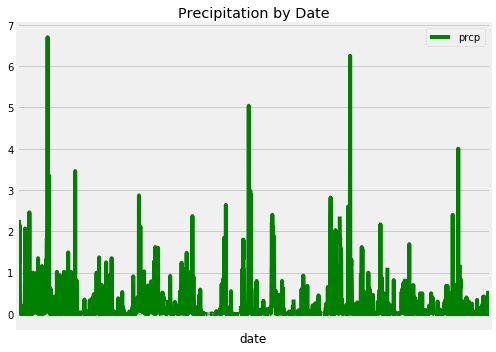

In [16]:
df1.plot(figsize=(7,5),color="green", title="Precipitation by Date")
index = np.arange(len(precp))
plt.xticks([])
plt.tight_layout()
plt.show()
#savefig

![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df1.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [18]:
# Design a query to show how many stations are available in this dataset?
station_ct=session.query(Station).count()
print(station_ct)

9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
act_station= session.query(Measurement.station, func.count(Measurement.station)).\
   group_by(Measurement.station).\
   order_by((func.count(Measurement.station)).desc()).all()
print(act_station)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature at the most active station?

rank_station = session.query(Measurement.station,\
               func.min(Measurement.tobs),\
               func.max(Measurement.tobs),\
               func.avg(Measurement.tobs)).group_by(Measurement.station).\
               filter(Measurement.station == 'USC00519281').all()
print(rank_station)

[('USC00519281', 54.0, 85.0, 71.66378066378067)]


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
alpha_station=session.query(Measurement.tobs).\
        filter(Measurement.station=='USC00519281').\
        filter(Measurement.date >= query_date).all()

print(alpha_station)

[(77.0,), (77.0,), (80.0,), (80.0,), (75.0,), (73.0,), (78.0,), (77.0,), (78.0,), (80.0,), (80.0,), (78.0,), (78.0,), (78.0,), (73.0,), (74.0,), (80.0,), (79.0,), (77.0,), (80.0,), (76.0,), (79.0,), (75.0,), (79.0,), (78.0,), (79.0,), (78.0,), (78.0,), (76.0,), (74.0,), (77.0,), (78.0,), (79.0,), (79.0,), (77.0,), (80.0,), (78.0,), (78.0,), (78.0,), (77.0,), (79.0,), (79.0,), (79.0,), (79.0,), (75.0,), (76.0,), (73.0,), (72.0,), (71.0,), (77.0,), (79.0,), (78.0,), (79.0,), (77.0,), (79.0,), (77.0,), (78.0,), (78.0,), (78.0,), (78.0,), (77.0,), (74.0,), (75.0,), (76.0,), (73.0,), (76.0,), (74.0,), (77.0,), (76.0,), (76.0,), (74.0,), (75.0,), (75.0,), (75.0,), (75.0,), (71.0,), (63.0,), (70.0,), (68.0,), (67.0,), (77.0,), (74.0,), (77.0,), (76.0,), (76.0,), (75.0,), (76.0,), (75.0,), (73.0,), (75.0,), (73.0,), (75.0,), (74.0,), (75.0,), (74.0,), (75.0,), (73.0,), (75.0,), (73.0,), (73.0,), (74.0,), (70.0,), (72.0,), (70.0,), (67.0,), (67.0,), (69.0,), (70.0,), (68.0,), (69.0,), (69.0,), 

In [22]:
df2 = pd.DataFrame(alpha_station, columns=['tobs'])
#df2.set_index(index, inplace=True, )


# Sort the dataframe by date
df2.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


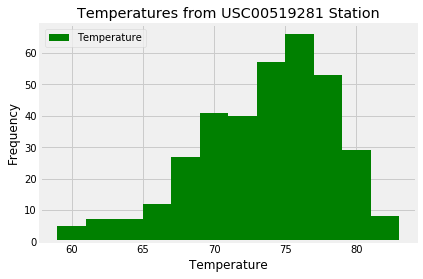

In [26]:
# use .hist to plot histogram
# keep putting in the bin into the picture looks like the example
# looks like 12 might be per each month so bins=12 makes sense
alpha_station_plot = df2['tobs'].hist(bins=12, color='green')
alpha_station_plot.set_title('Temperatures from USC00519281 Station')
alpha_station_plot.set_xlabel('Temperature')
alpha_station_plot.set_ylabel('Frequency')
#add legend
plt.legend(["Temperature"],loc= 'best', prop={'size': 10})
plt.show()
#fig.savefig("Images/Histograph.png")

![precipitation](Images/station-histogram.png)

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
start_date=2010,5,31
end_date=2010,6,5

In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2010-05-31', '2012-06-05'))


[(56.0, 72.55767516491353, 87.0)]


In [30]:
trip=calc_temps('2010-05-31', '2010-06-05')
trip

[(67.0, 74.68627450980392, 81.0)]

In [31]:
df3 = pd.DataFrame(trip,columns=['min','max','avg'])
#df2.set_index(index, inplace=True, )


# Sort the dataframe by date
df3.head()

,min,max,avg
0,67.0,74.686275,81.0


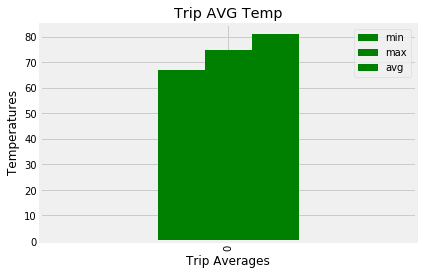

In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df3.plot.bar(color="green",  align='center', width=0.3,title="Trip AVG Temp")
#index = np.arange(len(trip))
#plt.xticks(index)
plt.xlabel('Trip Averages')
plt.ylabel('Temperatures')

plt.show()



In [38]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
rain_fall=session.query(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        filter(Measurement.tobs).\
        filter(Measurement.station).all()
rain_fall

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


InterfaceError: (sqlite3.InterfaceError) Error binding parameter 0 - probably unsupported type.
[SQL: SELECT measurement.date >= ? AS anon_1 
FROM measurement 
WHERE measurement.date <= ? AND measurement.tobs AND measurement.station]
[parameters: ((2010, 5, 31), (2010, 6, 5))]
(Background on this error at: http://sqlalche.me/e/rvf5)

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
